<a href="https://colab.research.google.com/github/arnavahuja/Transliteration_English_Hindi/blob/master/Transliteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial Imports 

In [ ]:
import numpy as np

import re
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torch.utils.data import Dataset
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
from IPython.display import HTML,clear_output

In [ ]:
device_gpu = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Basic Setup

In [ ]:
"""Creating a dictionary for the english characters to be used later including a pad character"""

eng_alphabets = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
pad_char = '-PAD-'

eng_alpha2index = {pad_char:0}
for index,alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1

#print(eng_alpha2index)

{'-PAD-': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'H': 8, 'I': 9, 'J': 10, 'K': 11, 'L': 12, 'M': 13, 'N': 14, 'O': 15, 'P': 16, 'Q': 17, 'R': 18, 'S': 19, 'T': 20, 'U': 21, 'V': 22, 'W': 23, 'X': 24, 'Y': 25, 'Z': 26}


In [ ]:
"""Creating a dictionary for the hindi characters to be used later including a pad character"""

hindi_alphabets = [chr(alpha) for alpha in range(2304,2432)]            #The hindi alphabets are in the ascii range 2304 to 2431
hindi_alpha_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char:0}
for index,alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1

#print(hindi_alpha2index)

{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 69, 'ॅ': 70, 'ॆ': 71, 'े': 72, 'ै': 73, 'ॉ': 74, 'ॊ': 75, 'ो': 76, 'ौ': 77, '्': 78, 'ॎ': 79, 'ॏ': 80, 'ॐ': 81, '॑': 82, '॒': 83, '॓': 84, '॔': 85, 'ॕ': 86, 'ॖ': 87, 'ॗ': 88, 'क़': 89, 'ख़': 90, 'ग़': 91, 'ज़': 92, 'ड़': 93, 'ढ़': 94, 'फ़': 95, 'य़': 96, 'ॠ': 97, 'ॡ': 98, 'ॢ': 99, 'ॣ': 100, '।': 101, '॥': 102, '०': 103, '१': 104, '२': 105, '३': 106, '४': 107, '५': 108, '६': 109, '७': 

In [ ]:
non_eng_letters_regex = re.compile('[^a-zA-Z ]')        #Using regular expressions package to remove all non english letters

#removing all english non-letters
def cleanEnglishVocab(line):
    line = line.replace('-',' ').replace(',',' ').upper()       #replacing comma and hyphen with space and converting all to upper-case
    line = non_eng_letters_regex.sub('',line)
    return line.split()                 #returning a list of the words in the line

#removing all hindi non_letters
def cleanHindiVocab(line):
    line = line.replace('-',' ').replace(',',' ')               #replacing comma and hyphen with space
    cleaned_line = ''
    for char in line:
        if char in hindi_alpha2index or char==' ':
            cleaned_line += char
    return cleaned_line.split()         #returning a list of the words in the line

In [ ]:
class TransliterationDataloader(Dataset):
    """Creating a dataloader for the dataset. Here the dataset is in the form of XML files"""
    """Read the xml file as well as clean the dataset for any abnormalities"""
    def __init__(self,filename):
        self.eng_words, self.hindi_words = self.read_XmlDataset(filename,cleanHindiVocab)
        self.shuffle_indices = list(range(len(self.eng_words)))
        random.shuffle(self.shuffle_indices)
        self.shuffle_start_index = 0

    def __len__(self):
        return len(self.eng_words)

    def __getitem__(self,idx):
        return self.eng_words[idx],self.hindi_words[idx]

    def read_XmlDataset(self,filename,lang_vocab_cleaner):          #Takes vocab cleaner as argument for easy changing to a different language
        transliterationCorpus = ET.parse(filename).getroot()        #Get the root of the xml tree 
        lang1_words = []
        lang2_words = []
        
        for line in transliterationCorpus:                          #Iterating through the XML tree
            wordlist1 = cleanEnglishVocab(line[0].text)
            wordlist2 = lang_vocab_cleaner(line[1].text)

            if len(wordlist1) != len(wordlist2):                                #removing abnormalities 
                print('Skipping:',line[0].text,'-',line[1].text)
                continue
            for word in wordlist1:
                lang1_words.append(word)
            for word in wordlist2:
                lang2_words.append(word)
        return lang1_words,lang2_words
    
    def get_random_sample(self):
        return self.__getitem__(np.random.randint(len(self.eng_words)))         #getting a random datapoint from the dataset
    
    def get_batch_from_array(self,batch_size,array):                            
        end = self.shuffle_start_index + batch_size
        batch = []

        if end>=len(self.eng_words):
            batch = [array[i] for i in self.shuffle_indices[0:end%len(self.eng_words)]]
            end = len(self.eng_words)
        return batch + [array[i] for i in self.shuffle_indices[self.shuffle_start_index:end]]
    
    def get_batch(self,batch_size,post_process=True):                           #getting a batch from the dataset
        eng_batch = self.get_batch_from_array(batch_size,self.eng_words)        
        hindi_batch = self.get_batch_from_array(batch_size,self.hindi_words)
        self.shuffle_start_index += batch_size+1
        
        #Reshuffle if 1 epoch is complete
        if self.shuffle_start_index>=len(self.eng_words):
            random.shuffle(self.shuffle_indices)
            self.shuffle_start_index = 0
        return eng_batch,hindi_batch
            

In [ ]:
train_data = TransliterationDataloader('NEWS2012TrainingEnHi13937.xml')         #Train Data
test_data = TransliterationDataloader('NEWS2012RefEnHi1000.xml')                #Test Data

Skipping: BARHARWA JUNCTION - बरहरवा
Skipping: STATE BNK TR - स्टेट बैंक ऑफ त्रावणकोर
Skipping: SOUTH ARLINGTON CHURCH OF CHRIST - साउथ अर्लिंग्टन
Skipping: KING EDWARD VII - किंग एडवर्ड
Skipping: DIBANG VALLEY - दिबंगवैली
Skipping: ORDER OF VASA - ऑडर ऑफ़ द वासा
Skipping: AZAMNAGAR ROAD - आज़मनगर
Skipping: CAPE TOWN - केपटाउन
Skipping: NEW ZEALAND - न्यूज़ीलैंड
Skipping: SEA OF THE HEBRIDES - सी ऑफ हरब्रिड्‍स
Skipping: RAMCOIND - राम्को इंड
Skipping: KELVINGROVE ART GALLERY AND MUSEUM - केल्व‍िनग्रोव आर्ट एण्ड म्युज़ियम
Skipping: AUSTRALIAN NATIONAL UNIVERSITY - ऑस्ट्रेलियननेशनल यूनिवर्सिटी
Skipping: JAHAN AARA - जहाँआरा
Skipping: NAVABHARAT FERRO ALLOYS - नव भारत फ़ैरो अलॉय
Skipping: RAMA LINGESHWARA - रामालिंगेश्वर
Skipping: FAKHRUN NISA - फखरुन्निसा
Skipping: REDIFF.COM INDIA LIMITED - रेडिफ़ डॉट कॉम इंडिया लिमिटेड
Skipping: OMKARNATH THAKUR - ओंकार नाथ ठाकुर
Skipping: OPENTV - ओपन टीवी
Skipping: ENVOY COMMUNICATIONS GROUP - एन्वॉय कम्युनिकेशंस
Skipping: WAR OF THE HOLY LEAGUE - वार ऑ

In [ ]:
"""Finding the tensor representation of an english/hindi word"""
def word_rep(word,letter2index,device='cpu'):
    rep = torch.zeros(len(word)+1,1,len(letter2index)).to(device)       #Shape = (length of word,batch_size(to be used later),total letters in dictionary)
    for letter_index,letter in enumerate(word):
        pos = letter2index[letter]              #getting representation of letter
        rep[letter_index][0][pos]=1             #adding the letter to the word tensor
    pad_pos = letter2index[pad_char]            #adding padding at the end
    rep[letter_index+1][0][pad_pos]=1
    return rep

"""Finding the tensor representation of ground truth"""
def gt_rep(word,letter2index,device='cpu'):
    gt_rep = torch.zeros([len(word)+1,1],dtype=torch.long).to(device)
    for letter_index,letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index+1][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep

In [ ]:
eng,hindi = train_data.get_random_sample()
eng_rep = word_rep(eng,eng_alpha2index)
#print(eng,eng_rep.shape)

In [ ]:
hindi_gt = gt_rep(hindi,hindi_alpha2index)      
#print(hindi,hindi_gt)

In [ ]:
"""Applying model to an input and producing an output"""
def infer(net,input,max_output_char=30,device='cpu'):
    input_rep = word_rep(input,eng_alpha2index).to(device)
    outputs = net(input_rep,max_output_char)
    return outputs

In [ ]:
"""An encoder decoder model with attention for the transliteration tast using GRU"""

MAX_OUTPUT_CHARS = 30
class Transliteration_EncoderDecoder_Attention(nn.Module):

    def __init__(self,input_size,hidden_size,output_size,verbose=False):
        super(Transliteration_EncoderDecoder_Attention,self).__init__()         

        self.hidden_size = hidden_size                                          #initializing the hidden size for the GRU
        self.output_size = output_size                                          #initializing the output size for the GRU

        self.encoder_rnn_cell = nn.GRU(input_size,hidden_size)                  
        self.decoder_rnn_cell = nn.GRU(hidden_size*2,hidden_size)

        self.h2o = nn.Linear(hidden_size,output_size)                           #output of the encoder 
        self.softmax = nn.LogSoftmax(dim=2)

        self.U = nn.Linear(self.hidden_size,self.hidden_size)                   #defining the matrices for adding attention 
        self.W = nn.Linear(self.hidden_size,self.hidden_size)
        self.Vattn = nn.Linear(self.hidden_size,1)
        self.out2hidden = nn.Linear(self.output_size,self.hidden_size)

        self.verbose = verbose                                                  #variable for bookkeeping
    
    def forward(self,input,max_output_chars=MAX_OUTPUT_CHARS,device='cpu',ground_truth=None):

        #encoder
        encoder_outputs,hidden = self.encoder_rnn_cell(input)
        encoder_outputs = encoder_outputs.view(-1,self.hidden_size)

        if self.verbose:
            print('Encoder output-',encoder_outputs.shape)

        #decoder
        decoder_state = hidden
        decoder_input = torch.zeros(1,1,self.output_size).to(device)
        outputs = []

        U = self.U(encoder_outputs)

        if self.verbose:
            print('Decoder state- ',decoder_state.shape)
            print('Decoder intermediate input- ',decoder_input.shape)
            print('U * Encoder output- ',U.shape)
            
        for i in range(max_output_chars):
            
            W = self.W(decoder_state.view(1,-1).repeat(encoder_outputs.shape[0],1))
            V = self.Vattn(torch.tanh(W+U))
            attn_weights = F.softmax(V.view(1,-1),dim=1)

            if self.verbose:
                print('W * DecoderState- ',W.shape)
                print('V- ',V.shape)
                print('Attn- ',attn_weights.shape)
            
            attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

            embedding = self.out2hidden(decoder_input)
            decoder_input = torch.cat((embedding[0],attn_applied[0]),1).unsqueeze(0)

            if self.verbose:
                print('Attn LC- ',attn_applied.shape)
                print('Decoder Input',decoder_input.shape)

            out,decoder_state = self.decoder_rnn_cell(decoder_input,decoder_state)

            if self.verbose:
                print('Decoder intermediate input- ',out.shape)
            
            out = self.h2o(decoder_state)
            out = self.softmax(out)
            outputs.append(out.view(1,-1))

            if self.verbose:
                print('Decoder output',out.shape)
                self.verbose=False

            max_idx = torch.argmax(out,2,keepdim=True)
            if not ground_truth is None:
                max_idx = ground_truth[i].reshape(1,1,1)
            one_hot = torch.FloatTensor(out.shape).to(device)
            one_hot.zero_()
            one_hot.scatter_(2,max_idx,1)

            decoder_input = one_hot.detach()

        return outputs

In [ ]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)

In [ ]:
out = infer(net_attn,'INDIA',30)

Encoder output- torch.Size([6, 256])
Decoder state-  torch.Size([1, 1, 256])
Decoder intermediate input-  torch.Size([1, 1, 129])
U * Encoder output-  torch.Size([6, 256])
W * DecoderState-  torch.Size([6, 256])
V-  torch.Size([6, 1])
Attn-  torch.Size([1, 6])
Attn LC-  torch.Size([1, 1, 256])
Decoder Input torch.Size([1, 1, 512])
Decoder intermediate input-  torch.Size([1, 1, 256])
Decoder output torch.Size([1, 1, 129])


In [ ]:
print(len(out))
for i in range(len(out)):
    print(out[i].shape,list(hindi_alpha2index.keys())[list(hindi_alpha2index.values()).index(torch.argmax(out[i]))])

30
torch.Size([1, 129]) क़
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १
torch.Size([1, 129]) १


In [ ]:
def train_batch(net,opt,criterion,batch_size,device='cpu',teacher_force=False):
    """Training the model for a batch of data for transliteration """
    net.train().to(device)
    opt.zero_grad()
    eng_batch,hindi_batch = train_data.get_batch(batch_size)

    total_loss=0
    for i in range(batch_size):
        input = word_rep(eng_batch[i],eng_alpha2index,device)                   #get the tensor representations of inputs
        gt = gt_rep(hindi_batch[i],hindi_alpha2index,device)                    #get the tensor representations of ground truth
        outputs = net(input,gt.shape[0],device,ground_truth=gt if teacher_force else None)

        for index,output in enumerate(outputs):
            loss = criterion(output,gt[index])/batch_size                       #find the loss using  negative logloss funciton
            loss.backward(retain_graph=True)                                    
            total_loss+=loss

    opt.step()
    return total_loss/batch_size

In [ ]:
net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)

In [ ]:
def calc_accuracy(net,device='cpu'):
    """Function for calculating the test accuracy"""
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(test_data)):
        eng,hindi = test_data[i]
        gt = gt_rep(hindi,hindi_alpha2index,device)
        outputs = infer(net,eng,gt.shape[0],device)
        correct = 0
        for index,out in enumerate(outputs):
            val,indices = out.topk(1)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct+=1
        accuracy+=correct/gt.shape[0]
    accuracy/=len(test_data)
    return accuracy

In [ ]:
def calc_accuracy_train(net,device='cpu'):
    """Funciton for calculating train accuracy"""
    net = net.eval().to(device)
    predictions = []
    accuracy = 0
    for i in range(len(train_data)):                #iterating over the train data 
        eng,hindi = train_data[i]
        gt = gt_rep(hindi,hindi_alpha2index,device)
        outputs = infer(net,eng,gt.shape[0],device)
        correct = 0
        for index,out in enumerate(outputs):        
            val,indices = out.topk(1)               #calculating accuracy using topk accuracy function. (k can be used as an input parameter)
            hindi_pos = indices.tolist()[0]
            if hindi_pos[0] == gt[index][0]:
                correct+=1
        accuracy+=correct/gt.shape[0]
    accuracy/=len(train_data)
    return accuracy

In [ ]:
def train_setup(net,lr=0.01,n_batches=100,batch_size=10,momentum=0.9,display_freq=5,device='cpu'):
    """Function encompassing the entire train setup"""
    net = net.to(device)
    criterion = nn.NLLLoss(ignore_index=-1)
    opt = optim.Adam(net.parameters(),lr=lr,weight_decay=1e-5)       
    teacher_force_upto = n_batches//100

    loss_arr = np.zeros(n_batches+1)

    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i +  train_batch(net,opt,criterion,batch_size,device=device,teacher_force=i<teacher_force_upto))/(i+1)

        if i%display_freq==0:
            clear_output(wait=True)

            print('Iteration',i,'Loss',loss_arr[i])
            plt.figure()
            plt.plot(loss_arr[1:i],'-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
    torch.save(net,'model.pt')
    return loss_arr

In [ ]:
net_attn = torch.load('Hindi_Eng_Model.pt')

In [ ]:
#net_attn = Transliteration_EncoderDecoder_Attention(len(eng_alpha2index),256,len(hindi_alpha2index),verbose=True)
#net_attn.to(device_gpu)

In [ ]:
accuracy = calc_accuracy(net_attn)*100
print(accuracy)

76.15793373293371


Iteration 40 Loss 0.06527220457792282


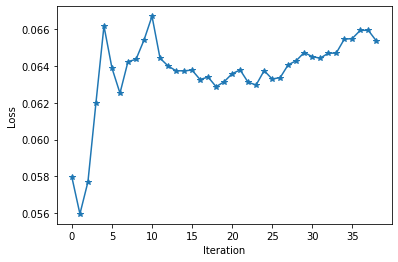

array([0.        , 0.05794512, 0.05595865, 0.05770024, 0.06199471,
       0.06617172, 0.06388726, 0.06252144, 0.06423812, 0.06435689,
       0.06540845, 0.06670225, 0.06442491, 0.06400037, 0.06373689,
       0.06373794, 0.06377374, 0.06326185, 0.06339822, 0.06287321,
       0.06314045, 0.06357741, 0.06378508, 0.06311057, 0.0629698 ,
       0.06374419, 0.06329262, 0.06336671, 0.06406233, 0.06428452,
       0.06473018, 0.06450854, 0.06442337, 0.06469156, 0.06469984,
       0.06545281, 0.06549253, 0.06593499, 0.06593882, 0.06536441,
       0.0652722 , 0.06480505, 0.06497199, 0.064827  , 0.06466226,
       0.06477021, 0.06474963, 0.06465378, 0.06454672, 0.06468923,
       0.06493166])

In [ ]:
train_setup(net_attn,lr=0.0001,n_batches=50,batch_size=64,display_freq=10,device=device_gpu)